 <style>
.cm-s-ipython .CodeMirror pre {
    font-size: 8pt; /* Adjust the font size*/
}
</style>

# **Homework 2:** Priors, regularization, and shrinkage
STATS348, UChicago, Spring 2024

----------------
**Daniel F. Noriega**

----------------

<a href="https://colab.research.google.com/github/aschein/stat_348_2024/blob/main/assignments/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Instructions

The purpose of this homework is apply the ideas from lectures 3 and 4 on regularizers, priors, and shrinkage.

Please fill out your answers in the provided spaces below. When you are finished, export the notebook as a PDF, making sure that all of your solutions are clearly visible.

Assignment is due **Saturday April 6, 11:59pm** on GradeScope.

----

## **Problem 1:** Regularization and Priors
              
Consider a standard regression setting with fixed design $X\in\mathbb{R}^{n\times p}$ and
$$
    y=X\beta+\varepsilon
$$
where $\varepsilon\sim\mathcal{N}(0,\sigma^2 I_p)$ for variance $\sigma^2$ considered known and fixed.

The **elastic net criterion** is a regularized loss function defined as $\ell_\mathrm{EN}(\lambda_1,\lambda_2,\beta)=\|y-X\beta\|_2^2 + \lambda_1\|\beta\|_1+\lambda_2\|\beta\|_2^2$, and the **elastic net estimator** is defined as its minimizer:
$$
\widehat{\beta}^\textrm{EN}(\lambda_1,\lambda_2):=\underset{\beta}{\textrm{argmin}} \,\, \ell_\mathrm{EN}(\lambda_1,\lambda_2,\beta)
$$
In lecture, we saw a correspondence between Ridge and LASSO estimators with MAP estimates under normal and Laplace priors, respectively. 

----
- **1a)** Provide the form **up to proportionality** of a prior density $P(\beta)$ on the regression coefficients such that the MAP estimate under $P(\beta)$ corresponds to $\widehat{\beta}^\mathrm{EN}(\lambda_1,\lambda_2)$. In the space below, please state $P(\beta)$ clearly, and provide a brief justification. 

$$P(\beta) \propto_{\beta} \exp(-\lambda_1 \|\beta\|_1 - \frac{\lambda_2}{2} \|\beta\|_2^2)$$

With elastic net criterion's components:
- The $\ell_1$ penalty term $\lambda_1 \|\beta\|_1$, analogous to a Laplace (double exponential) prior.
- The $\ell_2$ penalty term $\lambda_2 \|\beta\|_2^2$, similar to a Gaussian (normal) prior.

Given the elastic net combines both LASSO ($\ell_1$ penalty) and Ridge ($\ell_2$ penalty) regularization, the corresponding prior density $P(\beta)$ is a combination of Laplace and Gaussian distributions.

The prior density reflecting the $\ell_1$ penalty (Laplace prior) is proportional to:
$$
\exp(-\lambda_1 \|\beta\|_1)
$$

The prior density reflecting the $\ell_2$ penalty (Gaussian prior) is proportional to:
$$
\exp(-\frac{\lambda_2}{2} \|\beta\|_2^2)
$$

Combining these, the prior density $P(\beta)$ corresponding to the elastic net penalty is proportional to:
$$
P(\beta) \propto \exp(-\lambda_1 \|\beta\|_1 - \frac{\lambda_2}{2} \|\beta\|_2^2)
$$

----

- **1b)** Consider a dataset where the input feature $x$ is generated from a uniform distribution over the interval $[-3,3]$, and the corresponding target $y$ is generated as
$$y_i=2x_i^3 - x_i^2 + \varepsilon_i$$
where $\varepsilon_i\sim\mathcal{N}(0,10)$ is a noise term (with _variance_ 10). Use the code block below to simulate a dataset of $n=20$ data points in Python.

In [1]:
import numpy as np

# Set the random seed for reproducibility
np.random.seed(123)

# Generate a dataset of 20 random numbers between -3 and 3
dataset = np.random.uniform(-3, 3, 20)

# Calculate y values based on function above
y_i = lambda x: (2*(x**3))-(x**2)+np.random.normal(0, np.sqrt(10))
y = [y_i(x) for x in dataset]

---
Now consider the following model of the data using a 5th degree polynomial regression. 
$$y_i=\beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \ldots + \beta_5 x_i^5 + \varepsilon_i$$
where the noise is assumed $\varepsilon_i \sim \mathcal{N}(0,1)$ (with _variance_ 1).
- **1c)**  Estimate the coefficients using maximum likelihood as $\widehat{\beta}^\mathrm{MLE}$. In the code block below, do this programmatically using scikit-learn's [PolynomialFeatures preprocessor](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). (You may have to import other methods/libraries as well.)

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Generate polynomial features
poly = PolynomialFeatures(degree=5, include_bias=True)
X_poly = poly.fit_transform(dataset.reshape(-1,1))

# Fit a linear regression model
model = LinearRegression(fit_intercept=False)
model.fit(X_poly, y)

# Get the estimated coefficients
beta_hat = model.coef_

print("Estimated coefficients (betas):", beta_hat)


Estimated coefficients (betas): [ 1.45430295  4.80997205 -2.33122497 -1.77261828 -0.0541137   0.43098714]


----
Now, consider a prior of $\beta\sim\mathcal{N}(0,\sigma_0^2)$ on the regression coefficients. 

- **1d)**: Provide the form of the MAP solution  $\widehat{\beta}^{\textrm{MAP}}(\sigma_0^2)$ below:

$$\widehat{\beta}^{\text{MAP}}(\sigma_0^2) = \underset{\beta}{\arg\min} \left\{ \frac{1}{2\sigma^2} \|y - X\beta\|^2 + \frac{1}{2\sigma_0^2} \|\beta\|^2 \right\} \\ = \left(X^T X+ \frac{\sigma^2}{\sigma_0^2}I\right)^{-1} X^T y$$

Where I is the identity matrix of size matching $\beta$ and $X$ is the observed data. This translates MAP estimation under a normal prior to a penalized regression problem, similar to Ridge. $\frac{\sigma^2}{\sigma_0^2}$ acts as a regularization parameter indicates the weight of the prior belief relative to the data.

---
- **1e)** In the code block below, implement the MAP estimator for a given $\sigma_0^2$ (using any methods or libraries you like):



In [3]:
from sympy import Matrix, eye

def map_estimate(y, X, sigma0):
    p = X.shape[1]
    I = eye(p)
    X_=Matrix(X)
    y_=Matrix(y)
    sigma2 = 10
    # Calculate the MAP estimate as described by equation in 1d)
    beta_map = ((X_.T*X_) + ((sigma2/(sigma0**2))*I)).inv()*X_.T*y_
    return np.array(beta_map).flatten()

----

- **1f)** Fit the MAP estimate to the synthetic data you generated above, experimenting with different values for $\sigma_0^2$. Find a value that seems "too large", a value that seems "too small", and a value that seems "just right" based on plotting and inspecting the learned regression functions. (These judgements are subjective, we are not expecting specific values, just reasonable ones.)  Once you have selected three values, display clearly in a single plot the following:

    - The dataset $(x_1,y_1),\ldots,(x_{20},y_{20})$

    - The estimated regression function using using $\widehat{\beta}_\mathrm{MLE}$
 
    - The three estimated regression functions $\widehat{\beta}^{\textrm{MAP}}(\sigma_0^2)$ for the selected three values of $\sigma_0^2$

    Make sure your plot includes a legend that clearly indicates the different functions.




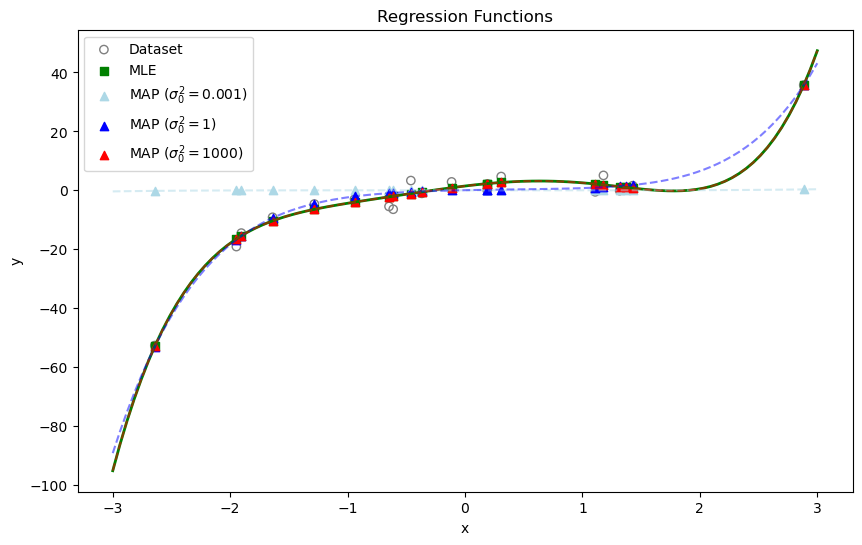

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a list of sigma_0^2 values
sigma_0_2_values = [0.001, 1, 1000]

# Calculate the MAP estimates for each sigma_0^2 value
beta_map_values = [map_estimate(y, X_poly, sigma_0_2) for sigma_0_2 in sigma_0_2_values]

# Calculate the predicted values using MLE
y_b_mle = [np.dot(beta_hat, x) for x in X_poly]

# Calculate the predicted values using MAP for each sigma_0^2 value
y_b_map = {}
for i in sigma_0_2_values:
    y_b_map[i] = [np.dot(map_estimate(y, X_poly, i), x) for x in X_poly]

# Create lines for ploting the regression functions
lines_x = np.linspace(-3, 3, 100)
lines_mle = [np.dot(beta_hat, poly.fit_transform(np.array(x).reshape(-1, 1)).flatten()) for x in lines_x]
lines_map = {}
for i in sigma_0_2_values:
    lines_map[i] = [np.dot(map_estimate(y, X_poly, i), poly.fit_transform(np.array(x).reshape(-1, 1)).flatten()) for x in lines_x]

# Ploting
plt.figure(figsize=(10, 6))
plt.scatter(dataset, y, color='grey', label='Dataset', marker='o', facecolors='none')

plt.scatter(dataset, y_b_mle, label='MLE', color='green', marker='s')
plt.plot(lines_x, lines_mle, color='green', linewidth=2)

colors = ['lightblue', 'blue', 'red']
for i in sigma_0_2_values:
    color = colors.pop(0)
    plt.scatter(dataset, y_b_map[i], label='MAP ($\sigma_0^2={}$)'.format(i), marker='^', color=color)
    plt.plot(lines_x, lines_map[i], color=color, alpha=0.5, linestyle='--')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Regression Functions')
plt.legend()
plt.show()

--- 
- **1g)** Discuss your findings plot above.

    - How does the MLE compare to the three different MAP solutions?
    
    - Why did you select the three values of $\sigma_0^2$ that you did? 

Intuitively, the **MLE** approach maximizes the based on the observed sample, while **MAP** considers our prior 'belief' on what the distribution for betas should look like through $\sigma_0^2$. With a $\sigma_0^2$ that is too small, regularization is too high, and data can only move beta values so much (underfitting, as seen in the plot above). With a $\sigma_0^2$ that seems right, there is an effect of the prior relative to the mle estimate, but the distribution captures the data appropriately as well. If $\sigma_0^2$ is too large, the prior is essentially uninformative, and we get a solution similar to MLE. 

I selected the values of $\sigma_0^2$ by visually inspecting the plot above for different values of $\sigma_0^2$ and thinking about the rationale above to understand what I saw.

--- 

## **Problem 2:** Estimating SEPs with binomial trials

#### **Setting**

It is May 1968 and the USS _Scorpion_ has just disappeared somewhere in the Atlantic Ocean, likely off the coast of Spain. You are the lone statistician on board the USS _Mizar_, which has been dispatched to find the missing submarine. Your job is to guide the search as best you can, given the data at your disposal.

#### **Search effectiveness probability (SEP)**
As we saw in lecture, an important component of our decision problem is the _search effectiveness probability_ of each search cell $k$

\begin{equation}
q_k = P(\textrm{finding the sub in $k$} \mid \textrm{sub is in $k$ and the divers search $k$})
\end{equation}

#### **Binomial trials**
To collect data that we can use to estimate these SEPs, our divers have been running trials to see if they can recover large objects thrown overboard in each cell $k$. Define the following quantity:
\begin{align}
y_k &\in \{0,\dots, n_k\}&\textrm{ the number of successful trials in $k$}
\end{align}

where $n_k$ is the total number of trials in $k$.
We will assume the following likelihood for $y_k$ given the SEP $q_k$:
\begin{align}
y_k &\stackrel{\textrm{ind.}}{\sim} \textrm{Binom}(n_k,\, q_k) \textrm{ for cell } k = 1\dots K
\end{align}

#### **Beta prior**
Now further assume the following prior for the SEPs:
\begin{align}
q_k &\stackrel{\textrm{iid}}{\sim} \textrm{Beta}(a_0,\,b_0) \textrm{ for cell } k = 1\dots K
\end{align}
where $a_0$ and $b_0$ are the Beta prior's shape parameters.


----

- **2a):** Provide an analytic expression (i.e., without any integrals) for the negative log marginal likelihood $-\log P(\boldsymbol{y}_{1:K} \mid \boldsymbol{n}_{1:K}, a_0,\,b_0\,)$ where $\boldsymbol{y}_{1:K}\equiv (y_{1},\dots,y_{K})$ and $\boldsymbol{n}_{1:K}\equiv (n_{1},\dots,n_{K})$ are the data across all cells. Provide your answer below, along with a brief justification.


\begin{equation}
\begin{aligned}
-\log P(\boldsymbol{y}_{1:K} \mid \boldsymbol{n}_{1:K}, a_0, b_0) &= -\sum_{k=1}^{K} \log \left(\binom{n_k}{y_k} \frac{B(y_k + a_0, n_k - y_k + b_0)}{B(a_0, b_0)}\right)
\\
&= -\sum_{k=1}^{K} \log \binom{n_k}{y_k} + \log B(y_k + a_0, n_k - y_k + b_0) - \log B(a_0, b_0)
\end{aligned}
\end{equation}

**Brief Justification**

$$
\text{Binomial Likelihood} \Longrightarrow P(y_k | n_k, q_k) = \binom{n_k}{y_k} q_k^{y_k} (1 - q_k)^{n_k - y_k} \\

\text{Beta Prior} \Longrightarrow P(q_k | a_0, b_0) = \frac{q_k^{a_0 - 1}(1 - q_k)^{b_0 - 1}}{B(a_0, b_0)} \\


\text{Marginal Likelihood} \Longrightarrow
P(y_k | n_k, a_0, b_0) = \int_0^1 P(y_k | n_k, q_k) P(q_k | a_0, b_0) dq_k \\
$$

This integrates to the beta-binomial distribution due to the conjugacy of the beta and binomial distributions:

$$
P(y_k | n_k, a_0, b_0) = \binom{n_k}{y_k} \frac{B(y_k + a_0, n_k - y_k + b_0)}{B(a_0, b_0)}
$$

Which after taking the $-1*log$ and expanding gives us the expression above.


----

- **2b):** In the code cell below, implement a function that takes in two arrays for $\boldsymbol{y}_{1:K}$ and $\boldsymbol{n}_{1:K}$, along with a value of the parameters $(a_0, b_0)$, and computes the negative marginal log likelihood. We recommend you use functions in the `numpy` and/or `scipy` Python libraries, but you may use any other libraries if you like.

In [5]:
import numpy as np
import scipy.stats as st    # for stats-related methods
import scipy.special as sp  # for special functions (e.g., gammaln)

def neg_log_marginal_likelihood(params, y, n):
    """ Calculate the negative log-marginal likelihood for the beta-binomial model.
    
    Args:
        params (tuple): the parameters of the marginal likelihood (a0, b0)
        y (array): the number of successes for each trial
        n (array): the number of trials
    
    Returns:
        float: the negative log-marginal likelihood
    """
    
    a0, b0 = params
    
    # Using gammaln for log(binomial coefficient) and betaln for log(beta function)
    log_binomial_coeff = sp.gammaln(n + 1) - (sp.gammaln(y + 1) + sp.gammaln(n - y + 1))
    log_beta_function = sp.betaln(y + a0, n - y + b0) - sp.betaln(a0, b0)
    
    # The negative log marginal likelihood is the sum of the negative log of the individual marginal likelihoods
    neg_log_marginal_likelihood = -np.sum(log_binomial_coeff + log_beta_function)
    
    return neg_log_marginal_likelihood

----

- **2c):** Now, in the code cell below, implement a method for fitting the parameters $(a_0, b_0)$ which relies on your implementation of the negative log marginal likelihood. We recommend using `scipy.optimize.minimize` (make sure to read [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) and to experiment with different settings). You are allowed to use other methods and libraries, if you so choose.

In [6]:
from scipy.optimize import minimize

def fit_marginal_likelihood(y, n):
    """ Fit the parameters of the marginal likelihood to the data.

    Args:
        y (array): the number of successes for each trial
        n (array): the number of trials

        If your function requires other input arguments, include a description here.
    
    Returns:
        tuple: the MLE for a0 and b0
    """

    initial_guess = [1, 1]
    bounds = [(0, None), (0, None)]
    parameters = minimize(neg_log_marginal_likelihood, initial_guess, args=(y, n), bounds=bounds, method='L-BFGS-B')
    a0_mle, b0_mle = parameters.x

    return a0_mle, b0_mle

----

- **2d):** Use your method to fit $a_0$ and $b_0$ to the trial data. In the cell below, load in the trial data and call your method. 

In [7]:
# load in the beta-binomial trial data
import pandas as pd
df_trials = pd.read_csv('binomial_trials.csv')
y = df_trials['n_successes'].values
n = df_trials['n_trials'].values

# if your fit_marginal_likelihood function takes extra args, modify this code to pass them in here.
a0_mle, b0_mle = fit_marginal_likelihood(y, n)

print(a0_mle, b0_mle)

3.785776958990971 4.604626945155411


----

- **2e):** This is an empirical Bayes procedure that can be loosely understood as "fitting the prior". In the code cell below, create a plot that visualizes the the PDF of the "fitted" Beta prior---i.e., $\textrm{Beta}(q;\, \widehat{a}_0\,\widehat{b}_0)$.

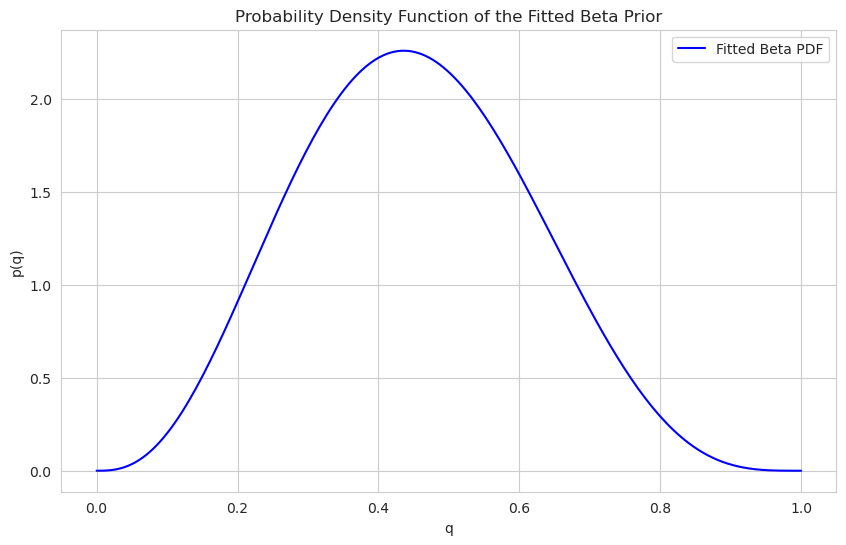

In [8]:
q_t=np.linspace(0,1,200)
p_t = st.beta.pdf(q_t, a0_mle, b0_mle)

plt.figure(figsize=(10, 6))
with sns.axes_style("whitegrid"):
    sns.lineplot(x=q_t, y=p_t, color='blue', label='Fitted Beta PDF')
    plt.xlabel('q')
    plt.ylabel('p(q)')
    plt.title('Probability Density Function of the Fitted Beta Prior')
    plt.legend()
    plt.grid(True)

plt.show()

---
- **2f)**: In the code cell below, use your fitted parameters $(\widehat{a}_0, \widehat{b}_0)$ to compute the posterior means of all $K$ SEPs $$\widehat{q}^{\textrm{post-mean}}_k = \mathbb{E}[q_k \mid y_k, n_k, \widehat{a}_0, \widehat{b}_0]$$
    and compare them to the maximum likelihood estimates $$\widehat{q}^{\textrm{MLE}}_k = \underset{q_k}{\textrm{argmax}}\, P(y_k \mid n_k, q_k)$$.
    More specifically:
    
    - Compute the posterior means.

    - Compute the maximum likelihood estimates.
    
    - Generate a scatter plot where each $(x,y)$ point is a pair $(\widehat{q}^{\textrm{MLE}}_k, \widehat{q}^{\textrm{post-mean}}_k)$ for all $k=1\dots K$. For reference, also include the line $x=y$, and make sure the $x$- and $y$-axis both range over the full set of possible values.


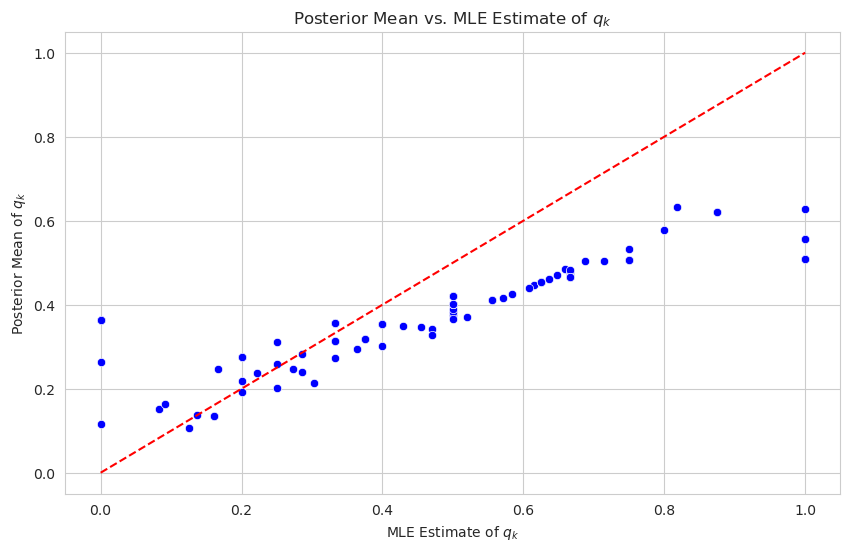

In [9]:
temp_df=df_trials.copy()
temp_df['q_post_mean']= (temp_df['n_successes']+a0_mle)/(temp_df['n_trials']+a0_mle+b0_mle+df_trials['n_trials']-df_trials['n_successes'])
temp_df['q_mle']=temp_df['n_successes']/temp_df['n_trials']

plt.figure(figsize=(10, 6))
with sns.axes_style("whitegrid"):
    sns.scatterplot(data=temp_df, x='q_mle', y='q_post_mean', color='blue')
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'r--')
    plt.xlabel('MLE Estimate of $q_k$')
    plt.ylabel('Posterior Mean of $q_k$')
    plt.title('Posterior Mean vs. MLE Estimate of $q_k$')
plt.show()

----

- **2f)**: Discuss the plot you just generated.

    - What is the relationship between the maximum likelihood estimates and the posterior means?

    - Why does this make sense based on your understanding of the procedure you have implemented?

    - Comment on any other observations or insights.


The plot depicts a positive correlation between the Maximum Likelihood Estimates (MLEs) and the posterior means for the parameter $q_k$, which reflects the Bayesian updating process: 

- The posterior means are influenced by both the empirical data and the prior distribution, effectively "regularizing" the MLEs towards the prior mean. This demonstrates a 'shrinkage' effect where MLE values are pulled towards a more central prior mean.
- The posterior means are adjusted upwards for lower MLE values, indicating the prior's influence. Conversely, for higher MLE values, the posterior means are adjusted downwards. (Points higher than the x=y line for low $q_k$ values, lower than the x=y line for high $q_k$ values)
- Smaller sample sizes may be less reliable and are adjusted more heavily based on the prior.
- Points close to the $y = x$ line suggest less influence from the prior, which is expected to occur when more data is available, resulting in more confident MLEs. Points further from the line indicate a stronger pull from the prior, which is expected to take place in cases of less data.

This visualization showcases Bayesian inference, where prior knowledge is integrated with the observed data to produce posterior estimates. It reflects the interplay between empirical evidence and prior beliefs in shaping our estimates.